<a href="https://colab.research.google.com/github/olsem1/WP-3/blob/master/KFold_%22LM%2C_Ridge%2C_DT%2C_RF%2C_XGB%2Bneer_cpi_2002_2019%2019.01.2021%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [470]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

!pip install pmdarima -q
#from pmdarima.arima import ADFTest
from pmdarima.arima import auto_arima


In [471]:
course = pd.read_excel('RC_2002-2020.xlsx')
course = course.rename(columns={"data": "date"})
course = course.set_index('date')
course_m = course.resample('MS').mean()

# **Переменные**

In [472]:
cpi = "month"
reg_names = ['RF_SA']
data_do = "2019-12-01"
train_do = "2018-01-01"

result_rmse = pd.DataFrame(columns=['month/year', 'reg_names', 'data_do', 'train_do', 'method', 'rmse'])
#result_rmse.append(cpi, reg_names, data_do, train_do, 'method', 'rmse')

In [473]:
data = pd.read_excel('cpi_reg.xls', sheet_name = cpi)
data = data.set_index('date')
data = data.interpolate(method='polynomial', order=2, axis=0)
data.isna().sum().sum()

0

In [474]:
data.tail(12)

,RF,RF_SA,BEL,BRY,VLA,VOR,IVA,KAL,KOS,KUR,LIP,MOS,ORL,RYA,SMO,TAM,TVE,TUL,YAR,MOW,KAR,KOM,ARK,VLG,KAG,LEN,MUR,NGR,PSK,SPB,ADY,KLM,KRA,AST,VGG,ROS,DAG,ING,KAB,KAO,...,STA,BAS,MAR,MOR,TAT,UDM,CHV,PER,KIR,NIZ,ORE,PNZ,SAM,SAR,ULY,KUG,SVE,TYU,CHE,ALI,TUV,KHK,ALT,KYA,IRK,KEM,NVS,OMS,TOM,BUR,SAH,ZAB,KAM,PRI,KHA,AMU,MAG,SAK,JEW,CHU
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-01,100.13,100.165728,100.06,100.50,100.26,100.21,99.97,100.03,100.20,100.03,100.27,100.04,100.39,100.33,100.12,100.23,100.17,100.05,100.21,100.06,100.08,99.48,100.08,100.51,100.34,100.06,100.29,100.06,100.21,100.12,99.97,100.14,99.88,100.05,100.25,100.03,100.72,100.43,100.30,100.38,...,100.20,100.47,100.23,100.02,100.11,100.19,100.27,99.97,100.07,100.24,100.15,100.13,100.27,100.13,100.01,100.27,100.12,99.81,99.99,100.20,100.40,100.15,100.19,100.15,100.37,100.28,100.37,100.19,100.31,100.16,99.99,100.52,100.24,100.28,99.92,100.28,100.11,100.25,100.11,100.09
2019-11-01,100.28,100.168582,100.12,100.29,100.23,100.41,100.37,100.53,100.48,100.16,100.32,100.26,100.38,100.45,100.41,100.14,100.20,100.45,100.58,100.28,100.23,100.34,100.31,100.20,100.21,100.41,100.24,100.21,99.96,100.17,100.15,100.69,100.25,100.14,100.31,100.21,100.75,100.37,100.39,100.56,...,100.41,100.01,100.25,100.19,100.26,100.20,100.11,100.34,100.19,100.32,100.21,100.16,100.38,100.43,100.07,100.28,100.27,100.46,100.36,100.25,100.23,100.40,100.27,100.27,100.10,100.26,100.15,100.16,100.43,100.52,100.06,100.13,100.10,100.19,100.48,100.34,100.25,100.64,100.35,100.26
2019-12-01,100.36,100.105186,100.23,100.53,100.18,100.20,100.48,100.47,100.44,100.40,100.23,100.30,100.31,100.25,100.24,100.41,100.52,100.39,100.12,100.33,100.57,100.70,100.50,100.34,100.38,100.28,100.50,100.31,100.23,100.37,100.55,100.60,100.25,100.35,100.35,100.42,100.56,100.37,100.41,100.46,...,100.29,100.23,100.33,100.39,100.32,100.42,100.15,100.56,100.55,100.16,100.24,100.27,100.23,100.62,100.54,100.29,100.47,100.60,100.43,100.46,100.41,100.34,100.26,100.52,100.54,100.26,100.31,100.56,100.31,100.19,100.44,100.21,100.21,100.29,100.28,100.54,100.45,100.40,100.28,100.13
2020-01-01,100.40,100.019991,100.53,100.28,100.76,100.74,100.48,100.12,100.32,100.51,100.53,100.25,100.16,100.40,100.38,100.26,100.25,100.59,100.59,100.42,100.51,101.86,100.64,100.41,100.60,100.29,100.28,100.76,100.49,100.71,100.83,100.41,100.37,100.42,100.58,100.32,100.35,100.52,100.50,100.75,...,100.57,100.34,100.21,100.12,100.29,100.36,100.41,100.28,100.18,100.66,100.16,100.45,100.43,100.78,100.21,100.35,100.07,100.09,100.43,100.25,100.36,100.16,100.56,100.24,100.24,100.13,100.26,100.11,100.47,100.87,99.80,100.62,100.38,100.48,100.54,100.73,99.55,100.48,100.50,100.10
2020-02-01,100.33,100.203534,100.19,100.29,100.29,100.31,100.42,100.63,100.45,100.27,100.21,100.32,100.47,100.23,100.26,100.14,100.29,100.40,100.65,100.22,100.57,100.81,100.40,100.39,100.25,100.26,100.46,100.37,100.22,100.15,100.11,99.79,100.33,100.02,100.23,100.26,100.20,100.13,100.40,100.28,...,100.50,100.39,100.50,100.27,100.42,100.21,100.20,100.46,100.35,100.01,100.06,100.26,100.48,100.74,100.50,100.41,100.22,100.49,100.15,100.41,100.34,100.38,100.46,100.63,100.52,100.61,100.38,100.54,100.46,100.34,100.52,100.42,100.13,100.54,100.55,100.38,100.62,100.33,100.63,100.58
2020-03-01,100.55,100.467636,100.61,100.74,100.82,100.85,100.90,100.59,100.44,100.64,100.53,100.37,100.44,100.62,100.82,100.66,100.83,101.30,100.64,100.33,100.60,100.16,100.42,100.75,100.72,100.49,100.45,100.75,100.54,100.79,100.28,100.64,100.65,100.69,100.58,100.61,101.75,100.44,100.67,100.82,...,100.47,100.80,100.46,100.69,100.35,100.47,100.32,100.34,100.73,100.98,100.61,100.78,100.58,100.86,100.63,100.61,100.41,100.49,100.50,100.07,100.65,100.58,100.48,100.24,100.16,100.73,100.89,100.25,100.30,100.46,100.06,100.73,100.16,99.96,100.03,100.50,100.76,100.40,100.45,100.59
2020-04-01,100.83,100.779865,100.95,100.80,100.91,101.06,100.88,101.34,100.69,101.32,101.04,100.65,101.10,101.30,101.40,101.29,1

# **Проверка на стационарность**

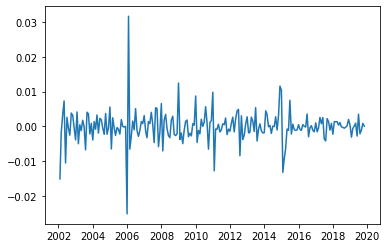

In [475]:
# to log  and diff
data_st = pd.DataFrame(index = data.index[1:])
#data_st = pd.DataFrame(index = data.index)

for region in data.columns:
#  data_st[region] = np.log(data[region].values)
  data_st[region] = np.diff(np.log(data[region].values))
data_st=(data_st[:-10])

plt.plot(data_st[reg_names])

In [476]:
from statsmodels.tsa.stattools import adfuller
%matplotlib inline
st = 0
notst = 0
p_value = 0.01
for num, region in enumerate(data_st.keys()):
  if region == 'RF':
    continue
  adf_result = adfuller(data_st[region])
  result_text = []
  result_text.append('ADF: {:.5}, '.format(adf_result[0]))
  result_text.append('p-val: {:.2}, '.format(adf_result[1]))
  if adf_result[1] < float(p_value):
      print('Регион:', region, 'p-val: {:.2}, '.format(adf_result[1]))
      st += 1
  else:
      print('Нестационарный ряд в регионе:', region, 'p-val: {:.2}, '.format(adf_result[1]))
      notst += 1
print('Нестационарных рядов всего:', notst, ' на уровне значимости , ', p_value)


Регион: RF_SA p-val: 1.9e-19, 
Регион: BEL p-val: 3.3e-15, 
Регион: BRY p-val: 3e-09, 
Регион: VLA p-val: 8.9e-10, 
Регион: VOR p-val: 1e-13, 
Регион: IVA p-val: 5.2e-11, 
Регион: KAL p-val: 5.3e-08, 
Регион: KOS p-val: 6.8e-09, 
Регион: KUR p-val: 1.8e-06, 
Регион: LIP p-val: 4.7e-10, 
Регион: MOS p-val: 1.3e-10, 
Регион: ORL p-val: 2.8e-10, 
Регион: RYA p-val: 2.8e-14, 
Регион: SMO p-val: 1.9e-10, 
Регион: TAM p-val: 1.3e-08, 
Регион: TVE p-val: 8.2e-19, 
Регион: TUL p-val: 3.2e-15, 
Регион: YAR p-val: 4.3e-18, 
Регион: MOW p-val: 1.1e-11, 
Регион: KAR p-val: 1.2e-10, 
Регион: KOM p-val: 1.3e-15, 
Регион: ARK p-val: 2.2e-08, 
Регион: VLG p-val: 2e-09, 
Регион: KAG p-val: 6.7e-16, 
Регион: LEN p-val: 7.5e-10, 
Регион: MUR p-val: 6.5e-13, 
Регион: NGR p-val: 8.3e-10, 
Регион: PSK p-val: 6.4e-09, 
Регион: SPB p-val: 5.8e-10, 
Регион: ADY p-val: 4e-06, 
Регион: KLM p-val: 5.8e-18, 
Регион: KRA p-val: 1.4e-15, 
Регион: AST p-val: 3.1e-18, 
Регион: VGG p-val: 2.2e-16, 
Регион: ROS p-val: 1

In [477]:
#if use stationary data
data=data_st
"""
# для стационарных рядов
data_st = data_st[reg_names]
data_st = data_st[:data_do]
data_st = data_st.merge(course_m, left_on='date', right_on='date')
data_st['month'] = pd.DatetimeIndex(data_st.index).month
train_st = data_st[data_st.index < train_do]
test_st = data_st[data_st.index >= train_do]
"""
# for ML
data = data[reg_names]
data = data[:data_do]
data = data.merge(course_m, left_on='date', right_on='date')
data['month'] = pd.DatetimeIndex(data.index).month
train = data[data.index < train_do]
test = data[data.index >= train_do]


In [478]:
test

,RF_SA,curs,month
date,,,
2018-01-01,-0.002268,56.498100,1
2018-02-01,0.001331,56.806705,2
2018-03-01,0.001310,57.063605,3
2018-04-01,0.001322,60.769890,4
2018-05-01,0.000349,62.230900,5
2018-06-01,0.001099,62.768505,6
2018-07-01,-0.000159,62.861948,7
2018-08-01,-0.000292,66.076409,8
2018-09-01,-0.000549,67.666095,9


# **ARIMA**

In [479]:
exogenous_features = ['month', 'curs']


/usr/local/lib/python3.6/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1462.470, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1302.578, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1376.834, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1471.606, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1304.556, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1502.825, Time=0.40 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1471.183, Time=0.85 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1499.084, Time=0.69 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1451.462, Time=0.82 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-1505.342, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1473.540, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-1506.697, Time=0.20 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.47 sec

Best model:  ARIMA(0,1,3)(0,0,

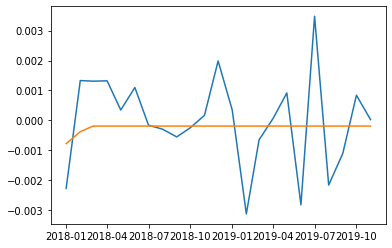

In [480]:
  # find best params for ARIMA
  stepwise_model = auto_arima (train[reg_names], start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=False, 
                               D=1, d=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

"""  stepwise_model = auto_arima(train[reg_names], start_p=1, start_q=1, max_p=3, max_q=3, m=1, start_P=0, seasonal=True, \
                              d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True, \
                              out_of_sample_size = test.shape[0], scoring = 'mse', information_criterion = 'oob')
  
stepwise_model = auto_arima(train_data['cpi_sfo'], start_p=1, start_q=1, max_p=3, max_q=3, m=1, start_P=0, seasonal=True,
                           d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
"""

stepwise_model.fit(train[reg_names])
future_forecast = stepwise_model.predict(n_periods=test.shape[0])
future_forecast = pd.DataFrame(future_forecast, index = test.index, columns=[reg_names])

plt.plot(test[reg_names])
plt.plot(future_forecast[reg_names])

print('rmse: {:.4f}'.format(mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5))
print('normed rmse: {:.4f}%'.format(mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5 / 
                                    np.mean(test[reg_names].values) * 100))


In [481]:
result = pd.DataFrame(np.array(future_forecast), index = test.index, columns=['ARIMA'])
result

,ARIMA
date,
2018-01-01,-0.000774
2018-02-01,-0.000377
2018-03-01,-0.000187
2018-04-01,-0.000187
2018-05-01,-0.000187
2018-06-01,-0.000187
2018-07-01,-0.000187
2018-08-01,-0.000187
2018-09-01,-0.000187


In [482]:
mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5

0.0015198721833751207

In [483]:
#result_rmse = pd.DataFrame(columns=['month/year', 'reg_names', 'data_do', 'train_do', 'method', 'rmse'])

result_arima = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'ARIMA', 'rmse': mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5} 
result_rmse = result_rmse.append(result_arima, ignore_index = True) 

In [484]:
result_rmse

,month/year,reg_names,data_do,train_do,method,rmse
0,month,[RF_SA],2019-12-01,2018-01-01,ARIMA,0.00152


# **ARIMAX**

/usr/local/lib/python3.6/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1456.590, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1298.947, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1373.071, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1466.339, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1300.920, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1501.040, Time=0.65 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1428.476, Time=0.97 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1494.346, Time=1.70 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1448.998, Time=1.28 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-1503.103, Time=0.93 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1468.226, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1429.385, Time=0.84 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-1498.060, Time=0.66 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1458.539, Time=0.53 sec
 ARIMA(1,1,3)(0,0,0

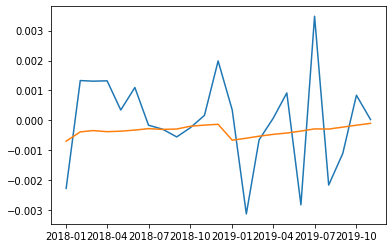

In [485]:
# find best params for ARIMAX
stepwise_model = auto_arima(train[reg_names], exogenous = train[exogenous_features], start_p=1, start_q=1, 
                            max_p=4, max_q=4, m=12, start_P=0, seasonal=False,
                            d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
  
stepwise_model.fit(train[reg_names], exogenous = train[exogenous_features])
future_forecast = stepwise_model.predict(n_periods=test.shape[0], exogenous = test[exogenous_features])
future_forecast = pd.DataFrame(future_forecast, index = test.index, columns=[reg_names])

plt.plot(test[reg_names])
plt.plot(future_forecast[reg_names])

print('rmse: {:.4f}'.format(mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5))
print('normed rmse: {:.4f}%'.format(mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5 / 
                                    np.mean(test[reg_names].values) * 100))

In [486]:
result['ARIMAX']=pd.DataFrame(np.array(future_forecast), index = test.index, columns=['ARIMAX'])

In [487]:
result

,ARIMA,ARIMAX
date,,
2018-01-01,-0.000774,-0.000692
2018-02-01,-0.000377,-0.000382
2018-03-01,-0.000187,-0.000338
2018-04-01,-0.000187,-0.000375
2018-05-01,-0.000187,-0.000359
2018-06-01,-0.000187,-0.000321
2018-07-01,-0.000187,-0.000273
2018-08-01,-0.000187,-0.000299
2018-09-01,-0.000187,-0.000286


In [488]:
result_arimax = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'ARIMAX', 
                'rmse': mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5} 
result_rmse = result_rmse.append(result_arimax, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,method,rmse
0,month,[RF_SA],2019-12-01,2018-01-01,ARIMA,0.00152
1,month,[RF_SA],2019-12-01,2018-01-01,ARIMAX,0.00152


# **Feature Engineering**

In [489]:
data_lags = pd.DataFrame()

data_lags['curs'] = data['curs'].values
data_lags['t'] = data[reg_names].values
for i in {1, 6, 12}:
    data_lags['t-'+str(i)] = data[reg_names].shift(i).values
    
data_lags.index = data.index
data_lags = data_lags[12:]
data_lags['month'] = pd.DatetimeIndex(data_lags.index).month
data_lags

,curs,t,t-1,t-12,t-6,month
date,,,,,,
2003-02-01,31.698979,0.004142,-0.003910,-0.015149,-0.000564,2
2003-03-01,31.453290,-0.005030,0.004142,-0.001746,-0.002553,3
2003-04-01,31.211786,0.000445,-0.005030,0.003296,0.003818,4
2003-05-01,30.907055,-0.001240,0.000445,0.007311,0.003156,5
2003-06-01,30.468626,0.001755,-0.001240,-0.010563,-0.000486,6
...,...,...,...,...,...,...
2019-07-01,63.222682,0.003477,-0.002815,-0.000159,0.000349,7
2019-08-01,65.587483,-0.002156,0.003477,-0.000292,-0.003119,8
2019-09-01,64.958705,-0.001101,-0.002156,-0.000549,-0.000648,9


In [490]:
df=data_lags
df.reset_index(drop=False, inplace=True)
lag_features = ["t", "curs"]
window1 = 3
window2 = 6
window3 = 12

df_rolled_3m = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_6m = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_12m = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3m = df_rolled_3m.mean().shift(1).reset_index().astype(np.float32)
df_mean_6m = df_rolled_6m.mean().shift(1).reset_index().astype(np.float32)
df_mean_12m = df_rolled_12m.mean().shift(1).reset_index().astype(np.float32)

df_std_3m = df_rolled_3m.std().shift(1).reset_index().astype(np.float32)
df_std_6m = df_rolled_6m.std().shift(1).reset_index().astype(np.float32)
df_std_12m = df_rolled_12m.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3m[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_6m[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_12m[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3m[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_6m[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_12m[feature]

df.fillna(df.mean(), inplace=True)

df.set_index("date", drop=True, inplace=True)
df.head(12)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.


,curs,t,t-1,t-12,t-6,month,t_mean_lag3,t_mean_lag6,t_mean_lag12,t_std_lag3,t_std_lag6,t_std_lag12,curs_mean_lag3,curs_mean_lag6,curs_mean_lag12,curs_std_lag3,curs_std_lag6,curs_std_lag12
date,,,,,,,,,,,,,,,,,,
2003-02-01,31.698979,0.004142,-0.003910,-0.015149,-0.000564,2,-0.000030,-0.000025,-0.000022,0.003375,0.003705,0.003968,39.198013,38.950359,38.446205,0.993415,1.506711,2.163328
2003-03-01,31.453290,-0.005030,0.004142,-0.001746,-0.002553,3,0.004142,0.004142,0.004142,0.003375,0.003705,0.003968,31.698978,31.698978,31.698978,0.993415,1.506711,2.163328
2003-04-01,31.211786,0.000445,-0.005030,0.003296,0.003818,4,-0.000444,-0.000444,-0.000444,0.006485,0.006485,0.006485,31.576134,31.576134,31.576134,0.173728,0.173728,0.173728
2003-05-01,30.907055,-0.001240,0.000445,0.007311,0.003156,5,-0.000148,-0.000148,-0.000148,0.004614,0.004614,0.004614,31.454685,31.454685,31.454685,0.243599,0.243599,0.243599
2003-06-01,30.468626,0.001755,-0.001240,-0.010563,-0.000486,6,-0.001942,-0.000421,-0.000421,0.002804,0.003807,0.003807,31.190710,31.317778,31.317778,0.273727,0.338430,0.338430
2003-07-01,30.360287,-0.000078,0.001755,0.002585,-0.003910,7,0.000320,0.000014,0.000014,0.001501,0.003438,0.003438,30.862490,31.147947,31.147947,0.373579,0.479701,0.479701
2003-08-01,30.349027,-0.006765,-0.000078,-0.000564,0.004142,8,0.000146,-0.000001,-0.000001,0.001510,0.003075,0.003075,30.578655,31.016670,31.016670,0.289515,0.536183,0.536183
2003-09-01,30.598633,0.004054,-0.006765,-0.002553,-0.005030,9,-0.001696,-0.001819,-0.000967,0.004484,0.003348,0.003797,30.392647,30.791679,30.921293,0.066041,0.472003,0.550686
2003-10-01,30.164713,0.003588,0.004054,0.003818,0.000445,10,-0.000930,-0.000305,-0.000340,0.005459,0.003646,0.003938,30.435982,30.649237,30.880960,0.140972,0.344015,0.522443


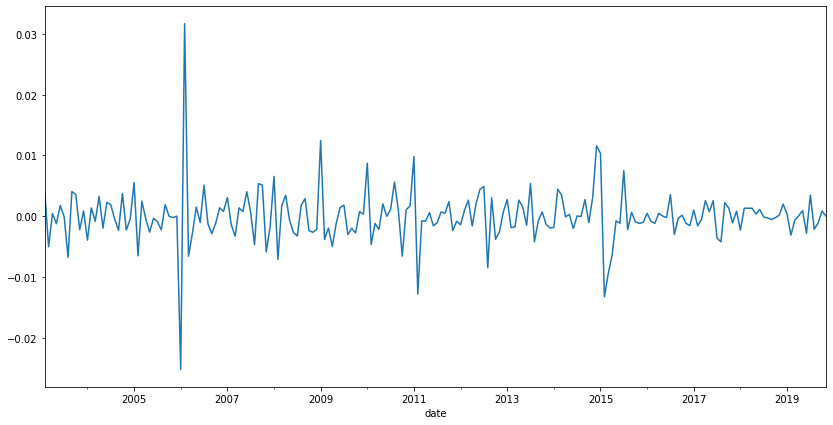

In [491]:
df.t.plot(figsize=(14, 7))

In [492]:
data = df
data_not = data.drop('t', axis=1)
train = data[data.index < train_do]
test = data[data.index >= train_do]

"""
X_train = train.values
y_train = train[['t']].values.ravel()
X_test = test.values
y_test = test[['t']].values.ravel()
"""
X_train = train.drop(['t'], axis=1).values
y_train = train[['t']].values.ravel()
X_test = test.drop(['t'], axis=1).values
y_test = test[['t']].values.ravel()


In [493]:
result['y_test']=pd.DataFrame(np.array(y_test), index = test.index, columns=['y_test'])
result

,ARIMA,ARIMAX,y_test
date,,,
2018-01-01,-0.000774,-0.000692,-0.002268
2018-02-01,-0.000377,-0.000382,0.001331
2018-03-01,-0.000187,-0.000338,0.001310
2018-04-01,-0.000187,-0.000375,0.001322
2018-05-01,-0.000187,-0.000359,0.000349
2018-06-01,-0.000187,-0.000321,0.001099
2018-07-01,-0.000187,-0.000273,-0.000159
2018-08-01,-0.000187,-0.000299,-0.000292
2018-09-01,-0.000187,-0.000286,-0.000549


# **KNeighborsRegressor**

In [494]:
!pip install mglearn -q

In [495]:
from sklearn.datasets import make_blobs
import mglearn
from sklearn.neighbors import KNeighborsRegressor

# instantiate the model 
KNmodel = KNeighborsRegressor(n_neighbors=20)
# fit the model using the training data and training targets
KNmodel.fit(X_train, y_train)

print("Training set score: {:.2f}".format(KNmodel.score(X_train, y_train)))
print("Test set score: {:.2f}".format(KNmodel.score(X_test, y_test)))

forecast = KNmodel.predict(X_test)
print('rmse: {:.4f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.01
Test set score: -0.02
rmse: 0.0015
normed rmse: -36887.4742%


In [496]:
result['KNR']=pd.DataFrame(np.array(forecast), index = test.index, columns=['KNR'])

In [497]:
result

,ARIMA,ARIMAX,y_test,KNR
date,,,,
2018-01-01,-0.000774,-0.000692,-0.002268,0.000071
2018-02-01,-0.000377,-0.000382,0.001331,0.000071
2018-03-01,-0.000187,-0.000338,0.001310,0.000071
2018-04-01,-0.000187,-0.000375,0.001322,0.000079
2018-05-01,-0.000187,-0.000359,0.000349,-0.000354
2018-06-01,-0.000187,-0.000321,0.001099,-0.000354
2018-07-01,-0.000187,-0.000273,-0.000159,-0.000261
2018-08-01,-0.000187,-0.000299,-0.000292,-0.000462
2018-09-01,-0.000187,-0.000286,-0.000549,-0.000412


In [498]:
result_KNR = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'KNR', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_KNR, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,method,rmse
0,month,[RF_SA],2019-12-01,2018-01-01,ARIMA,0.001520
1,month,[RF_SA],2019-12-01,2018-01-01,ARIMAX,0.001520
2,month,[RF_SA],2019-12-01,2018-01-01,KNR,0.001546


# **OLS**

In [499]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train, y_train)
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

forecast = lr.predict(X_test)
print('rmse: {:.4f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.36
Test set score: -0.93
rmse: 0.0021
normed rmse: -50662.0380%


In [500]:
result['OLS']=pd.DataFrame(np.array(forecast), index = test.index, columns=['OLS'])
result

,ARIMA,ARIMAX,y_test,KNR,OLS
date,,,,,
2018-01-01,-0.000774,-0.000692,-0.002268,0.000071,0.000850
2018-02-01,-0.000377,-0.000382,0.001331,0.000071,0.003154
2018-03-01,-0.000187,-0.000338,0.001310,0.000071,0.001571
2018-04-01,-0.000187,-0.000375,0.001322,0.000079,0.002881
2018-05-01,-0.000187,-0.000359,0.000349,-0.000354,0.002538
2018-06-01,-0.000187,-0.000321,0.001099,-0.000354,0.002278
2018-07-01,-0.000187,-0.000273,-0.000159,-0.000261,0.000289
2018-08-01,-0.000187,-0.000299,-0.000292,-0.000462,0.001453
2018-09-01,-0.000187,-0.000286,-0.000549,-0.000412,0.001640


In [501]:
result_OLS = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'OLS', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_OLS, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,method,rmse
0,month,[RF_SA],2019-12-01,2018-01-01,ARIMA,0.001520
1,month,[RF_SA],2019-12-01,2018-01-01,ARIMAX,0.001520
2,month,[RF_SA],2019-12-01,2018-01-01,KNR,0.001546
3,month,[RF_SA],2019-12-01,2018-01-01,OLS,0.002123


# **Ridge (l2-regularisation)**

In [502]:
from sklearn.linear_model import Ridge

ridge = Ridge().fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge.score(X_test, y_test)))

forecast = ridge.predict(X_test)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.07
Test set score: -1.42
rmse: 0.00238
normed rmse: -56804.60%


In [503]:
ridge10 = Ridge(alpha=10).fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge10.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge10.score(X_test, y_test)))

forecast = ridge10.predict(X_test)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.06
Test set score: -1.22
rmse: 0.00228
normed rmse: -54422.97%


In [504]:
ridge01 = Ridge(alpha=0.1).fit(X_train, y_train)
print("Training set score: {:.5f}".format(ridge01.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge01.score(X_test, y_test)))

forecast = ridge01.predict(X_test)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.07897
Test set score: -1.41
rmse: 0.00237
normed rmse: -56636.13%


In [505]:
result['Ridge']=pd.DataFrame(np.array(forecast), index = test.index, columns=['Ridge'])
result

,ARIMA,ARIMAX,y_test,KNR,OLS,Ridge
date,,,,,,
2018-01-01,-0.000774,-0.000692,-0.002268,0.000071,0.000850,0.001579
2018-02-01,-0.000377,-0.000382,0.001331,0.000071,0.003154,0.001531
2018-03-01,-0.000187,-0.000338,0.001310,0.000071,0.001571,0.001687
2018-04-01,-0.000187,-0.000375,0.001322,0.000079,0.002881,0.003065
2018-05-01,-0.000187,-0.000359,0.000349,-0.000354,0.002538,0.002463
2018-06-01,-0.000187,-0.000321,0.001099,-0.000354,0.002278,0.001321
2018-07-01,-0.000187,-0.000273,-0.000159,-0.000261,0.000289,0.000243
2018-08-01,-0.000187,-0.000299,-0.000292,-0.000462,0.001453,0.001385
2018-09-01,-0.000187,-0.000286,-0.000549,-0.000412,0.001640,0.001554


In [506]:
result_Ridge = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'Ridge', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_Ridge, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,method,rmse
0,month,[RF_SA],2019-12-01,2018-01-01,ARIMA,0.001520
1,month,[RF_SA],2019-12-01,2018-01-01,ARIMAX,0.001520
2,month,[RF_SA],2019-12-01,2018-01-01,KNR,0.001546
3,month,[RF_SA],2019-12-01,2018-01-01,OLS,0.002123
4,month,[RF_SA],2019-12-01,2018-01-01,Ridge,0.002374


# **Lasso (l1-regularisation)**

In [507]:
from sklearn.linear_model import Lasso

lasso = Lasso().fit(X_train, y_train)
print("Training set score: {:.2f}".format(lasso.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso.coef_ != 0))

forecast = lasso.predict(X_test)
print('rmse: {:.4f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.00
Test set score: -0.00
Number of features used: 0
rmse: 0.0015
normed rmse: -36519.89%


In [508]:
# we increase the default setting of "max_iter",
# otherwise the model would warn us that we should increase max_iter.
lasso001 = Lasso(alpha=0.01, max_iter=100000).fit(X_train, y_train)
print("Training set score: {:.2f}".format(lasso001.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso001.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso001.coef_ != 0))

forecast = lasso001.predict(X_test)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.00
Test set score: -0.00
Number of features used: 0
rmse: 0.00153
normed rmse: -36519.89%


In [509]:
result['Lasso']=pd.DataFrame(np.array(forecast), index = test.index, columns=['Lasso'])
result

,ARIMA,ARIMAX,y_test,KNR,OLS,Ridge,Lasso
date,,,,,,,
2018-01-01,-0.000774,-0.000692,-0.002268,0.000071,0.000850,0.001579,-0.000046
2018-02-01,-0.000377,-0.000382,0.001331,0.000071,0.003154,0.001531,-0.000046
2018-03-01,-0.000187,-0.000338,0.001310,0.000071,0.001571,0.001687,-0.000046
2018-04-01,-0.000187,-0.000375,0.001322,0.000079,0.002881,0.003065,-0.000046
2018-05-01,-0.000187,-0.000359,0.000349,-0.000354,0.002538,0.002463,-0.000046
2018-06-01,-0.000187,-0.000321,0.001099,-0.000354,0.002278,0.001321,-0.000046
2018-07-01,-0.000187,-0.000273,-0.000159,-0.000261,0.000289,0.000243,-0.000046
2018-08-01,-0.000187,-0.000299,-0.000292,-0.000462,0.001453,0.001385,-0.000046
2018-09-01,-0.000187,-0.000286,-0.000549,-0.000412,0.001640,0.001554,-0.000046


In [510]:
result_Lasso = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'Lasso', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_Lasso, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,method,rmse
0,month,[RF_SA],2019-12-01,2018-01-01,ARIMA,0.001520
1,month,[RF_SA],2019-12-01,2018-01-01,ARIMAX,0.001520
2,month,[RF_SA],2019-12-01,2018-01-01,KNR,0.001546
3,month,[RF_SA],2019-12-01,2018-01-01,OLS,0.002123
4,month,[RF_SA],2019-12-01,2018-01-01,Ridge,0.002374
5,month,[RF_SA],2019-12-01,2018-01-01,Lasso,0.001531


# **ElasticNet (l1+l2-regularisation)**

In [511]:
from sklearn.linear_model import ElasticNet
ENmodel = ElasticNet(alpha=0.01, max_iter=100000, random_state=0)
ENmodel.fit(X_train, y_train)
print("Training set score: {:.2f}".format(ENmodel.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ENmodel.score(X_test, y_test)))
print("Number of features used:", np.sum(ENmodel.coef_ != 0))

forecast = ENmodel.predict(X_test)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.00
Test set score: -0.00
Number of features used: 0
rmse: 0.00153
normed rmse: -36519.89%


In [512]:
result['ElasticNet']=pd.DataFrame(np.array(forecast), index = test.index, columns=['ElasticNet'])
result

,ARIMA,ARIMAX,y_test,KNR,OLS,Ridge,Lasso,ElasticNet
date,,,,,,,,
2018-01-01,-0.000774,-0.000692,-0.002268,0.000071,0.000850,0.001579,-0.000046,-0.000046
2018-02-01,-0.000377,-0.000382,0.001331,0.000071,0.003154,0.001531,-0.000046,-0.000046
2018-03-01,-0.000187,-0.000338,0.001310,0.000071,0.001571,0.001687,-0.000046,-0.000046
2018-04-01,-0.000187,-0.000375,0.001322,0.000079,0.002881,0.003065,-0.000046,-0.000046
2018-05-01,-0.000187,-0.000359,0.000349,-0.000354,0.002538,0.002463,-0.000046,-0.000046
2018-06-01,-0.000187,-0.000321,0.001099,-0.000354,0.002278,0.001321,-0.000046,-0.000046
2018-07-01,-0.000187,-0.000273,-0.000159,-0.000261,0.000289,0.000243,-0.000046,-0.000046
2018-08-01,-0.000187,-0.000299,-0.000292,-0.000462,0.001453,0.001385,-0.000046,-0.000046
2018-09-01,-0.000187,-0.000286,-0.000549,-0.000412,0.001640,0.001554,-0.000046,-0.000046


In [513]:
result_ElasticNet = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'ElasticNet', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_ElasticNet, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,method,rmse
0,month,[RF_SA],2019-12-01,2018-01-01,ARIMA,0.001520
1,month,[RF_SA],2019-12-01,2018-01-01,ARIMAX,0.001520
2,month,[RF_SA],2019-12-01,2018-01-01,KNR,0.001546
3,month,[RF_SA],2019-12-01,2018-01-01,OLS,0.002123
4,month,[RF_SA],2019-12-01,2018-01-01,Ridge,0.002374
5,month,[RF_SA],2019-12-01,2018-01-01,Lasso,0.001531
6,month,[RF_SA],2019-12-01,2018-01-01,ElasticNet,0.001531


# **DecisionTree**

In [514]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=2, random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

forecast = tree.predict(X_test)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Accuracy on training set: 0.339
Accuracy on test set: -0.008
rmse: 0.00154
normed rmse: -36660.66%


In [515]:
result['DecisionTree']=pd.DataFrame(np.array(forecast), index = test.index, columns=['DecisionTree'])
result

,ARIMA,ARIMAX,y_test,KNR,OLS,Ridge,Lasso,ElasticNet,DecisionTree
date,,,,,,,,,
2018-01-01,-0.000774,-0.000692,-0.002268,0.000071,0.000850,0.001579,-0.000046,-0.000046,0.000137
2018-02-01,-0.000377,-0.000382,0.001331,0.000071,0.003154,0.001531,-0.000046,-0.000046,0.000137
2018-03-01,-0.000187,-0.000338,0.001310,0.000071,0.001571,0.001687,-0.000046,-0.000046,0.000137
2018-04-01,-0.000187,-0.000375,0.001322,0.000079,0.002881,0.003065,-0.000046,-0.000046,0.000137
2018-05-01,-0.000187,-0.000359,0.000349,-0.000354,0.002538,0.002463,-0.000046,-0.000046,0.000137
2018-06-01,-0.000187,-0.000321,0.001099,-0.000354,0.002278,0.001321,-0.000046,-0.000046,0.000137
2018-07-01,-0.000187,-0.000273,-0.000159,-0.000261,0.000289,0.000243,-0.000046,-0.000046,0.000137
2018-08-01,-0.000187,-0.000299,-0.000292,-0.000462,0.001453,0.001385,-0.000046,-0.000046,0.000137
2018-09-01,-0.000187,-0.000286,-0.000549,-0.000412,0.001640,0.001554,-0.000046,-0.000046,0.000137


In [516]:
result_DT = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'DT', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_DT, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,method,rmse
0,month,[RF_SA],2019-12-01,2018-01-01,ARIMA,0.001520
1,month,[RF_SA],2019-12-01,2018-01-01,ARIMAX,0.001520
2,month,[RF_SA],2019-12-01,2018-01-01,KNR,0.001546
3,month,[RF_SA],2019-12-01,2018-01-01,OLS,0.002123
4,month,[RF_SA],2019-12-01,2018-01-01,Ridge,0.002374
5,month,[RF_SA],2019-12-01,2018-01-01,Lasso,0.001531
6,month,[RF_SA],2019-12-01,2018-01-01,ElasticNet,0.001531
7,month,[RF_SA],2019-12-01,2018-01-01,DT,0.001537


# **Random Forest**

rmse: 0.00363
normed rmse: -86556.012%
Accuracy on training set: 0.845
Accuracy on test set: -4.622


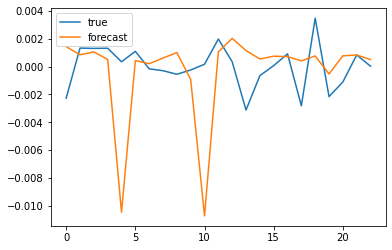

In [517]:
from sklearn.ensemble import RandomForestRegressor

RFmodel = RandomForestRegressor(n_estimators=500, random_state=42)
RFmodel.fit(X_train, y_train)
forecast = RFmodel.predict(X_test)

plt.plot(y_test, label='true')
plt.plot(forecast, label='forecast')
plt.legend()

print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.3f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / 
                                    np.mean(y_test) * 100))

print("Accuracy on training set: {:.3f}".format(RFmodel.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(RFmodel.score(X_test, y_test)))

In [518]:
result['Random Forest']=pd.DataFrame(np.array(forecast), index = test.index, columns=['Random Forest'])
result

,ARIMA,ARIMAX,y_test,KNR,OLS,Ridge,Lasso,ElasticNet,DecisionTree,Random Forest
date,,,,,,,,,,
2018-01-01,-0.000774,-0.000692,-0.002268,0.000071,0.000850,0.001579,-0.000046,-0.000046,0.000137,0.001438
2018-02-01,-0.000377,-0.000382,0.001331,0.000071,0.003154,0.001531,-0.000046,-0.000046,0.000137,0.000851
2018-03-01,-0.000187,-0.000338,0.001310,0.000071,0.001571,0.001687,-0.000046,-0.000046,0.000137,0.001058
2018-04-01,-0.000187,-0.000375,0.001322,0.000079,0.002881,0.003065,-0.000046,-0.000046,0.000137,0.000520
2018-05-01,-0.000187,-0.000359,0.000349,-0.000354,0.002538,0.002463,-0.000046,-0.000046,0.000137,-0.010461
2018-06-01,-0.000187,-0.000321,0.001099,-0.000354,0.002278,0.001321,-0.000046,-0.000046,0.000137,0.000438
2018-07-01,-0.000187,-0.000273,-0.000159,-0.000261,0.000289,0.000243,-0.000046,-0.000046,0.000137,0.000212
2018-08-01,-0.000187,-0.000299,-0.000292,-0.000462,0.001453,0.001385,-0.000046,-0.000046,0.000137,0.000618
2018-09-01,-0.000187,-0.000286,-0.000549,-0.000412,0.001640,0.001554,-0.000046,-0.000046,0.000137,0.001007


In [519]:
result_RF = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'RF', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_RF, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,method,rmse
0,month,[RF_SA],2019-12-01,2018-01-01,ARIMA,0.001520
1,month,[RF_SA],2019-12-01,2018-01-01,ARIMAX,0.001520
2,month,[RF_SA],2019-12-01,2018-01-01,KNR,0.001546
3,month,[RF_SA],2019-12-01,2018-01-01,OLS,0.002123
4,month,[RF_SA],2019-12-01,2018-01-01,Ridge,0.002374
5,month,[RF_SA],2019-12-01,2018-01-01,Lasso,0.001531
6,month,[RF_SA],2019-12-01,2018-01-01,ElasticNet,0.001531
7,month,[RF_SA],2019-12-01,2018-01-01,DT,0.001537
8,month,[RF_SA],2019-12-01,2018-01-01,RF,0.003628


In [520]:
RFmodel.feature_importances_

array([0.02603649, 0.12783813, 0.041813  , 0.03596703, 0.06256832,
       0.09716989, 0.15497057, 0.13663206, 0.1333979 , 0.03106239,
       0.02517475, 0.01722701, 0.01154925, 0.0130824 , 0.02507747,
       0.03948799, 0.02094535])

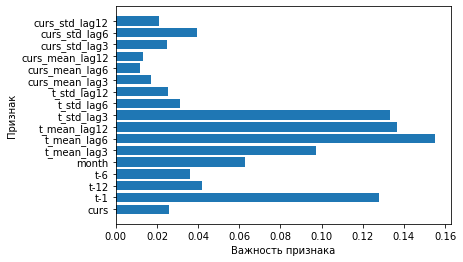

In [521]:
def plot_features(model):
  n_features = data_not.shape[1]
  plt.barh(range(n_features), model.feature_importances_, align='center')
  plt.yticks(np.arange(n_features), data_not.columns)
  plt.xlabel('Важность признака')
  plt.ylabel('Признак')
plot_features(RFmodel)

# **Кроссвалидация**

In [522]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(RFmodel, X_train, y_train, cv=3)
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Cross-validation scores: [-0.07492319  0.01003056 -0.40154538]
Average cross-validation score: -0.16


In [523]:
from sklearn.model_selection import cross_validate
res = cross_validate(RFmodel, X_train, y_train, cv=4,
                     return_train_score=True)
display(res)

{'fit_time': array([0.9903779 , 1.04933381, 1.0350616 , 1.0246377 ]),
 'score_time': array([0.02877021, 0.02992129, 0.02987194, 0.02936935]),
 'test_score': array([-0.13002608,  0.03170845,  0.14141646, -0.46680581]),
 'train_score': array([0.85968201, 0.83587652, 0.84323958, 0.8566008 ])}

In [524]:
res_df = pd.DataFrame(res)
display(res_df)
print("Mean times and scores:\n", res_df.mean())

,fit_time,score_time,test_score,train_score
0,0.990378,0.028770,-0.130026,0.859682
1,1.049334,0.029921,0.031708,0.835877
2,1.035062,0.029872,0.141416,0.843240
3,1.024638,0.029369,-0.466806,0.856601


Mean times and scores:
 fit_time       1.024853
score_time     0.029483
test_score    -0.105927
train_score    0.848850
dtype: float64


# **Slide test**

In [525]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
#startdate = pd.to_datetime(data_do)
startdate = pd.to_datetime(train_do)+ relativedelta(months=1)

#print('Today: ', startdate.strftime('%Y-%m-%d'))
#print(date_after_month.strftime('%Y-%m-%d'))
#startdate = str(startdate)[:10]
startdate

Timestamp('2018-02-01 00:00:00')

rmse: 0.0073
normed rmse: -174534.8191%


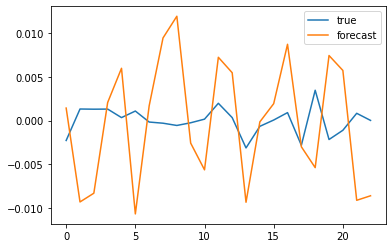

In [526]:
#forecast = RFmodel.predict(X_test)
#slide_test = test[test.index == train_do][data_not.columns.values].values
#print(slide_test)
slide_test = X_test
forecast = []
forecast.append(RFmodel.predict(slide_test)[0])

for i in range(test.shape[0] - 1):
  
  slide_test_next = slide_test.copy()
  slide_test_next[0, 1] = forecast[-1]

  slide_test_next[0, 0] += 1
  slide_test_next[0, 2:] = slide_test[0, 1:-1]
  
  #print(slide_test_next)
  slide_test = slide_test_next.copy()

  forecast.append(RFmodel.predict(slide_test)[0])

forecast = np.array(forecast)

plt.plot(y_test, label='true')
plt.plot(forecast, label='forecast')
plt.legend()

print('rmse: {:.4f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format((mean_squared_error(y_test, forecast) ** 0.5) / np.mean(y_test) * 100))


In [527]:
result_RFST = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'RFST', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_RFST, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,method,rmse
0,month,[RF_SA],2019-12-01,2018-01-01,ARIMA,0.001520
1,month,[RF_SA],2019-12-01,2018-01-01,ARIMAX,0.001520
2,month,[RF_SA],2019-12-01,2018-01-01,KNR,0.001546
3,month,[RF_SA],2019-12-01,2018-01-01,OLS,0.002123
4,month,[RF_SA],2019-12-01,2018-01-01,Ridge,0.002374
5,month,[RF_SA],2019-12-01,2018-01-01,Lasso,0.001531
6,month,[RF_SA],2019-12-01,2018-01-01,ElasticNet,0.001531
7,month,[RF_SA],2019-12-01,2018-01-01,DT,0.001537
8,month,[RF_SA],2019-12-01,2018-01-01,RF,0.003628
9,month,[RF_SA],2019-12-01,2018-01-01,RFST,0.007315


# **KFold cross validation**

In [528]:
#!pip install mglearn -q
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import mglearn


In [529]:
%%time
model = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=1)
#model.fit(X_train, y_train)

scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [-0.3724992   0.02553724  0.23140387 -0.65686725 -2.54042905]
CPU times: user 592 ms, sys: 8.82 ms, total: 600 ms
Wall time: 606 ms


In [530]:
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Average cross-validation score: -0.66


# **Stratified K-Fold cross-validation and other strategies**

In [531]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=3)

In [532]:
print("Cross-validation scores:\n{}".format(
      cross_val_score(model, X_train, y_train, cv=kfold)))

Cross-validation scores:
[-0.08343416 -0.00542239 -0.59777542]


In [533]:
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
print("Cross-validation scores:\n{}".format(
    cross_val_score(model, X_train, y_train, cv=kfold)))

Cross-validation scores:
[-0.1459941  -0.12336327 -0.07201372]


# **GradientBoostingRegressor**

In [534]:
from xgboost import XGBRegressor

[10:24:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rmse: 0.0014
normed rmse: -34133.2543%
Accuracy on training set: 0.961
Accuracy on test set: 0.126


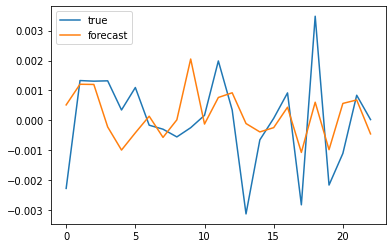

In [535]:
xgb_model = XGBRegressor(n_estimators=10000, learning_rate=0.01, max_depth=3)
xgb_model.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_train, y_train)], verbose=False)
# make predictions
xgb_forecast = xgb_model.predict(X_test)
xgb_model.feature_importances_
plt.plot(y_test, label='true')
plt.plot(xgb_forecast, label='forecast')
plt.legend()

from sklearn.metrics import mean_squared_error
print('rmse: {:.4f}'.format(mean_squared_error(y_test, xgb_forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format((mean_squared_error(y_test, xgb_forecast) ** 0.5) / 
                                    np.mean(y_test) * 100))

print("Accuracy on training set: {:.3f}".format(xgb_model.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(xgb_model.score(X_test, y_test)))

In [536]:
result['GradientBoosting']=pd.DataFrame(np.array(xgb_forecast), index = test.index, columns=['GradientBoosting'])
result

,ARIMA,ARIMAX,y_test,KNR,OLS,Ridge,Lasso,ElasticNet,DecisionTree,Random Forest,GradientBoosting
date,,,,,,,,,,,
2018-01-01,-0.000774,-0.000692,-0.002268,0.000071,0.000850,0.001579,-0.000046,-0.000046,0.000137,0.001438,0.000518
2018-02-01,-0.000377,-0.000382,0.001331,0.000071,0.003154,0.001531,-0.000046,-0.000046,0.000137,0.000851,0.001208
2018-03-01,-0.000187,-0.000338,0.001310,0.000071,0.001571,0.001687,-0.000046,-0.000046,0.000137,0.001058,0.001201
2018-04-01,-0.000187,-0.000375,0.001322,0.000079,0.002881,0.003065,-0.000046,-0.000046,0.000137,0.000520,-0.000217
2018-05-01,-0.000187,-0.000359,0.000349,-0.000354,0.002538,0.002463,-0.000046,-0.000046,0.000137,-0.010461,-0.000988
2018-06-01,-0.000187,-0.000321,0.001099,-0.000354,0.002278,0.001321,-0.000046,-0.000046,0.000137,0.000438,-0.000413
2018-07-01,-0.000187,-0.000273,-0.000159,-0.000261,0.000289,0.000243,-0.000046,-0.000046,0.000137,0.000212,0.000141
2018-08-01,-0.000187,-0.000299,-0.000292,-0.000462,0.001453,0.001385,-0.000046,-0.000046,0.000137,0.000618,-0.000565
2018-09-01,-0.000187,-0.000286,-0.000549,-0.000412,0.001640,0.001554,-0.000046,-0.000046,0.000137,0.001007,0.000020


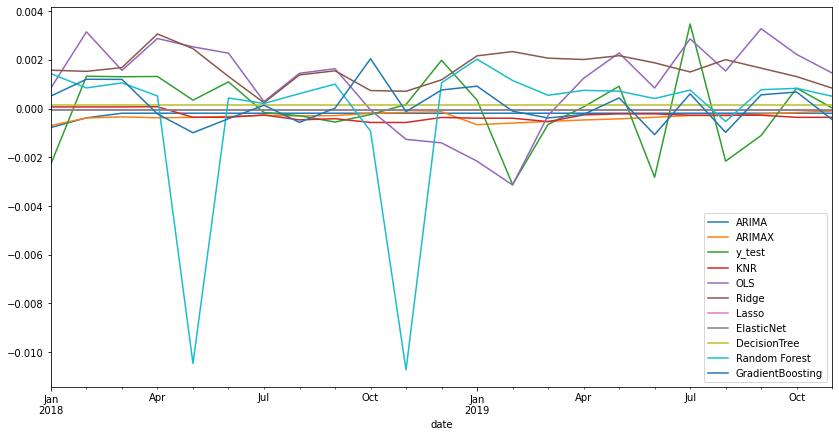

In [537]:
result.plot(figsize=(14, 7))

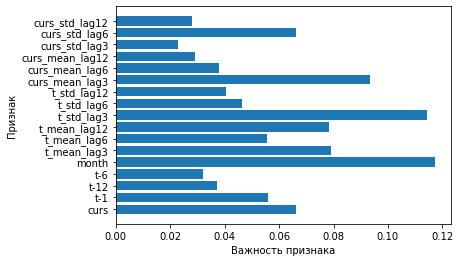

In [538]:
def plot_features(model):
  n_features = data_not.shape[1]
  plt.barh(range(n_features), model.feature_importances_, align='center')
  plt.yticks(np.arange(n_features), data_not.columns)
  plt.xlabel('Важность признака')
  plt.ylabel('Признак')
plot_features(xgb_model)

In [539]:
result_XGB = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'XGB', 
                'rmse': mean_squared_error(y_test, xgb_forecast) ** 0.5} 
result_rmse = result_rmse.append(result_XGB, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,method,rmse
0,month,[RF_SA],2019-12-01,2018-01-01,ARIMA,0.001520
1,month,[RF_SA],2019-12-01,2018-01-01,ARIMAX,0.001520
2,month,[RF_SA],2019-12-01,2018-01-01,KNR,0.001546
3,month,[RF_SA],2019-12-01,2018-01-01,OLS,0.002123
4,month,[RF_SA],2019-12-01,2018-01-01,Ridge,0.002374
5,month,[RF_SA],2019-12-01,2018-01-01,Lasso,0.001531
6,month,[RF_SA],2019-12-01,2018-01-01,ElasticNet,0.001531
7,month,[RF_SA],2019-12-01,2018-01-01,DT,0.001537
8,month,[RF_SA],2019-12-01,2018-01-01,RF,0.003628
9,month,[RF_SA],2019-12-01,2018-01-01,RFST,0.007315
